[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/trim-filter-messages.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239435-lesson-4-trim-and-filter-messages)

# 消息过滤和裁剪

## 回顾

现在，我们对一些事情有了一个更深入的了解: 

* 怎样自定义图的状态模式
* 怎样定义自定义状态reducers
* 怎样使用多图状态模式

## 目标

现在，我们可以开始使用这些概念在 LangGraph中断模型!
 
在接下来的几节课中，我们将构建一个具有长期记忆的聊天机器人。

因为我们的机器人将使用消息，让我们首先详细讨论一下在图状态中处理消息的高级方法。

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph langchain_openai

In [1]:
import os, getpass

def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")

_set_env("OPENAI_API_KEY")

In [1]:
# 我没有openai的api key，所以使用qwen的openai兼容接口，需要设置qwen的api key和base url，我选择从配置文件.yml中读取
import yaml

with open('../.yml', 'r') as file:
    config = yaml.safe_load(file)

# 获取配置信息(以.yml_example的例子)
qwen_config = config['llm']['qwen']

我们将使用 [LangSmith](https://docs.smith.langchain.com/) 来 [追踪](https://docs.smith.langchain.com/concepts/tracing)。

我们记录到一个项目 `langchain-study`.。

In [3]:
import os
smith_config = config['langsmith']
# _set_env("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_API_KEY"] = smith_config['key']
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "langchain-study"

## 消息作为状态

首先，让我们定义一些消息。

In [4]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
messages = [AIMessage(f"So you said you were researching ocean mammals?", name="Bot")]
messages.append(HumanMessage(f"Yes, I know about whales. But what others should I learn about?", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?


回忆我们可以将他们传递给一个聊天模型。

In [5]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model="qwen-max", base_url=qwen_config['base_url'], api_key=qwen_config['api_key'], temperature=0.5)
llm.invoke(messages)

AIMessage(content='Great! If you\'re already familiar with whales, there are several other fascinating ocean mammals to explore. Here are a few:\n\n1. **Dolphins**: These highly intelligent and social animals belong to the same family as whales (Cetacea). They are known for their playful behavior and complex communication systems. There are many species of dolphins, including the bottlenose dolphin, which is one of the most well-known.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have a more rounded head. They are also part of the Cetacea family. The harbor porpoise and the vaquita (a critically endangered species) are examples of porpoises.\n\n3. **Seals and Sea Lions**: These are pinnipeds, which means "fin-footed." Seals and sea lions are semi-aquatic, spending time both in water and on land. Seals are generally less vocal and more streamlined, while sea lions are more vocal and have visible ear flaps. Examples include the harbor seal, the California 

我们可以在一个简单的使用 `MessagesState` 的图中运行我们的聊天模型。

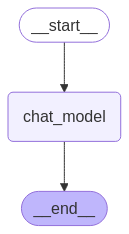

In [6]:
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

# Node
def chat_model_node(state: MessagesState):
    return {"messages": llm.invoke(state["messages"])}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [7]:
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! If you're already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, including the bottlenose dolphin, which is one of the most well-known.

2. **Porpoises**: Often confused with dolphins, porpoises are smaller and have a more rounded head. The harbor porpoise and the vaquita (which is critically endangered) are examples of porpoises.

3. **Seals and Sea Lions**: These are pinnipeds, whic

## Reducer

当我们与消息打交道时，一个实际的挑战是管理长时间进行的对话。

如果我们不小心，长时间的对话将导致高令牌使用和延迟，因为我们向模型传递的消息列表会不断增长。

我们有几种方法区解决这个问题。

首先，回忆我们看到的使用 `RemoveMessage` 和 `add_messages` reducer 的小技巧。

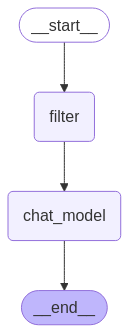

In [8]:
from langchain_core.messages import RemoveMessage

# Nodes
def filter_messages(state: MessagesState):
    # Delete all but the 2 most recent messages
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"messages": delete_messages}

def chat_model_node(state: MessagesState):    
    return {"messages": [llm.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("filter", filter_messages)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "filter")
builder.add_edge("filter", "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
# Message list with a preamble
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Invoke
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! If you're already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, such as the bottlenose dolphin, which is one of the most well-known.

2. **Porpoises**: Often confused with dolphins, porpoises are actually a different family of marine mammals. They are generally smaller and have a more rounded head compared to dolphins. The harbor porpoise is one of the most common species.

3. **Seal

## 过滤消息

如果你不需要或希望更改图状态，你可以只过滤你传递给聊天模型的消息。

例如：仅传递一个过滤后的列表 `llm.invoke(messages[-1:])` 给模型。

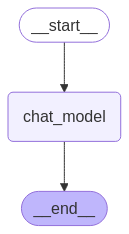

In [10]:
# Node
def chat_model_node(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"][-1:])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

让我们将已存在的消息列表，追加上LLM的回复，并追加一个后续问题。

In [11]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me more about Narwhals!", name="Lance"))

In [12]:
for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! If you're already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, such as the bottlenose dolphin, which is one of the most well-known.

2. **Porpoises**: Often confused with dolphins, porpoises 

In [13]:
# Invoke, using message filtering
output = graph.invoke({'messages': messages})
for m in output['messages']:
    m.pretty_print()

================================== Ai Message ==================================
Name: Bot

Hi.
================================ Human Message =================================
Name: Lance

Hi.
================================== Ai Message ==================================
Name: Bot

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, I know about whales. But what others should I learn about?
================================== Ai Message ==================================

Great! If you're already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:

1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, such as the bottlenose dolphin, which is one of the most well-known.

2. **Porpoises**: Often confused with dolphins, porpoises 

状态中包含所有的消息.

但是，让我们看一下 LangSmith 追踪，以查看模型调用只使用了最后一条消息：

https://smith.langchain.com/public/2837ad12-c505-4563-8f99-3cadaf368bf2/r/f3491dda-bf2f-44c2-a4bd-a3d035f17727

## 消息裁剪

另一种方法是基于固定数量的token的[消息裁剪](https://python.langchain.com/v0.2/docs/how_to/trim_messages/#getting-the-last-max_tokens-tokens)。

这将限制消息历史记录到指定token的数量。

当过滤仅返回智能体之间传递的消息的子集时，裁剪限制了模型响应时可使用的token数量。

请参见下边的 `trim_messages` 。

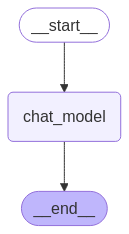

In [35]:
from langchain_core.messages import trim_messages, BaseMessage
from typing import List

# Node
def chat_model_node(state: MessagesState):
    messages = trim_messages(
            state["messages"],
            max_tokens=700,
            strategy="last",
            # 这里ChatOpenAI作为token计数器实际上并不需要与openai的模型交互，是纯本地计算，但是model仅支持openai的部分模型，所以这里暂时用gpt-4o粗略计算一下（理论上应自己写一个符合qwen情况的token计算器），又由于ChatOpenAI初始化必须有api_key，所以这里随便指定一个
            token_counter=ChatOpenAI(model="gpt-4o", api_key="no_user_because_local_calculation"),
            allow_partial=False,
        )
    return {"messages": [llm.invoke(messages)]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("chat_model", chat_model_node)
builder.add_edge(START, "chat_model")
builder.add_edge("chat_model", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages.append(output['messages'][-1])
messages.append(HumanMessage(f"Tell me where Orcas live!", name="Lance"))
messages

[AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
 HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
 AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
 AIMessage(content='Great! If you\'re already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:\n\n1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, such as the bottlenose dolphin, which is one of the most well-known.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are actually a different family of marine mammals. They are generally s

In [30]:
# Example of trimming messages
trim_messages(
    messages,
    max_tokens=700,
    strategy="last",
    # 这里ChatOpenAI作为token计数器实际上并不需要与openai的模型交互，是纯本地计算，但是model仅支持openai的部分模型，所以这里暂时用gpt-4o粗略计算一下，又由于ChatOpenAI初始化必须有api_key，所以这里随便指定一个
    token_counter=ChatOpenAI(model="gpt-4o", api_key="no_user_because_local_calculation"),
    allow_partial=False
)

[HumanMessage(content='Tell me more about Narwhals!', additional_kwargs={}, response_metadata={}, name='Lance', id='1188d323-d8a9-4def-8710-88fcc7f4c615'),
 AIMessage(content='Narwhals are fascinating marine mammals that are often referred to as the "unicorns of the sea" due to the long, spiraled tusk that protrudes from the head of males. Here are some interesting facts about narwhals:\n\n### Physical Characteristics\n- **Tusks**: The most distinctive feature of narwhals is their tusk, which is actually an elongated canine tooth. It can grow up to 10 feet (3 meters) long and is found in males, though occasionally in females as well. The tusk is not used for fighting but may play a role in communication, navigation, and sensing environmental changes.\n- **Size and Appearance**: Narwhals are medium-sized whales, with adults typically measuring between 13 to 18 feet (4 to 5.5 meters) in length and weighing around 1,800 to 3,500 pounds (800 to 1,600 kg). They have a mottled black and whit

In [36]:
# Invoke, using message trimming in the chat_model_node 
messages_out_trim = graph.invoke({'messages': messages})

In [37]:
messages_out_trim

{'messages': [AIMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Bot', id='1'),
  HumanMessage(content='Hi.', additional_kwargs={}, response_metadata={}, name='Lance', id='2'),
  AIMessage(content='So you said you were researching ocean mammals?', additional_kwargs={}, response_metadata={}, name='Bot', id='3'),
  HumanMessage(content='Yes, I know about whales. But what others should I learn about?', additional_kwargs={}, response_metadata={}, name='Lance', id='4'),
  AIMessage(content='Great! If you\'re already familiar with whales, there are several other fascinating ocean mammals you might want to explore. Here are a few:\n\n1. **Dolphins**: Highly intelligent and social, dolphins are known for their playful behavior and complex communication. There are many species of dolphins, such as the bottlenose dolphin, which is one of the most well-known.\n\n2. **Porpoises**: Often confused with dolphins, porpoises are actually a different family of marine mammals. The

让我们看一下 LangSmith 追踪来查看模型的调用：

https://smith.langchain.com/public/f0215f64-f151-4f80-ba46-033f9a131c1e/r/0d14e8e1-c7b4-442b-85db-deb1aeb00379